# 0. Setup

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
#sys.path.insert(0, "../../../knockpy-dev/knockpy/")
import knockpy
print(knockpy.__version__)
from knockpy.knockoff_filter import KnockoffFilter as KF
sys.path.insert(0, "../")
from mlr_src import gen_data
sys.path.insert(0, "../real_data/")
from hiv_data import get_duplicate_columns, elapsed

import warnings
from plotnine import *

def calc_mean_sem(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'sem', 'count']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_se'] = agg_df[m]['sem']
        agg_df[f'{m}_count'] = agg_df[m]['count']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_se']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_se']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

1.3.4


In [15]:
def seqstep_plot(W, fdr=0.1, beta=None):
    inds = np.argsort(-1*np.abs(W))
    sortW = W[inds]
    tau = knockpy.knockoff_stats.data_dependent_threshhold(sortW, fdr=fdr)
    tau = np.argmin(np.abs(sortW) >= tau)
    fig, ax = plt.subplots()
    x = np.arange(W.shape[0])
    if beta is None:
        flags = sortW >= 0
    else:
        flags = beta[inds] != 0
    ax.bar(x[flags], sortW[flags], color='blue')
    ax.bar(x[~flags], sortW[~flags], color='red')
    ax.axvline(tau, color='black', linestyle='dotted')
    plt.show()

def plot_W_path(W, beta):
    """
    Given feature-statistics W and a vector of coefficients beta,
    creates a dataframe used for plotting.
    """
    p = W.shape[0]
    inds = np.argsort(-1*np.abs(W), axis=0)
    sortW = np.take_along_axis(W, inds, axis=0)
    sortbeta = np.take_along_axis(beta, inds, axis=0)
    df = pd.DataFrame()
    df['W'] = sortW
    df['rank'] = np.arange(p)
    df['beta'] = sortbeta
    df['Null'] = df['beta'] == 0
    return df

In [16]:
def compute_Tdf(Wdf, fdr=0.05):
    """Thresholds for plots for HIV data"""
    Tdf = []
    for knockoff_type in Wdf['knockoff_type'].unique():
        for fstat in Wdf['fstat'].unique():
            for drug in Wdf['drug'].unique():
                for drug_type in Wdf['drug_type'].unique():
                    subWdf = Wdf.loc[
                        (Wdf['fstat'] == fstat) &
                        (Wdf['drug_type'] == drug_type) &
                        (Wdf['drug'] == drug)
                    ]
                    if len(subWdf) > 0:
                        subW = subWdf['W'].values
                        thresh = knockpy.knockoff_stats.data_dependent_threshhold(subW, fdr=fdr)
                        rank = np.argmax(np.abs(subW) < thresh) - 1/3
                        Tdf.append(
                            [fstat, knockoff_type, drug_type, drug, rank, ' -', thresh]
                        )
    return pd.DataFrame(
        Tdf, 
        columns=['fstat', 'knockoff_type', 'drug_type', 'drug', 'rank', 'sign(W)', 'thresh']
    )

In [26]:
import glob

FSTAT_NAMES = {
    "lcd":"LCD", 
    "lsm":"LSM", 
    "lcd_studentized":"LCD\n(studentized)", 
    "mlr":"MLR", 
    "oracle":"MLR\n(oracle)",
    "amlr":"AMLR",
}

def load_data_by_job_id(job_ids):
    # load all files
    if not isinstance(job_ids, list):
        job_ids = [job_ids]
    files = []
    for job_id in job_ids:
        files.extend(glob.glob(f"../data/sims_*/**/*id{job_id}*.csv", recursive=True))
    print(f"Found {len(files)} files")
    # load data
    data = []
    for f in files:
        data.append(pd.read_csv(f))
    df = pd.concat(data)
    # renaming
    if 'fstat' in df.columns:
        fstats = set(list(df['fstat'].unique()))
        unexpected_fstats = fstats - set(list(FSTAT_NAMES.keys()))
        if len(unexpected_fstats) > 0:
            print(f"WARNING: unexpected fstats = {unexpected_fstats}") 
        df['fstat'] = df['fstat'].map(FSTAT_NAMES)
    if 'knockoff_type' in df.columns:
        df['knockoff_type'] = df['knockoff_type'].str.upper()
    if 'covmethod' in df.columns:
        df['covmethod'] = df['covmethod'].str.upper()
    # return
    return df


# 1. Section 2 simulations

## 2.1 Simlated W-statistic plot

In [154]:
np.random.seed(12345)
probs = np.concatenate(
    [np.ones(25) * 0.9999, 
     np.ones(10) * 0.75, 
     np.ones(15) * 0.5], 
    axis=0
)
signs = 2 * np.random.binomial(1, probs) - 1

# setting 1
p = 50
Wabs = np.random.uniform(size=p)
Wabs = np.around(Wabs / Wabs.max(), 8)
W1 = Wabs * signs

# setting 2
Wabs = probs / probs.max()
Wabs = np.around(Wabs + 0.01 * np.random.uniform(0.9, 1, size=p), 8)  # tiebreaking
W2 = Wabs * signs

In [155]:
s1 = 'Random |W|'
s2 = "|W| ordered by P(W > 0)"
df1 = plot_W_path(W1, probs)
df1['setting'] = s1
df2 = plot_W_path(W2, probs)
df2['setting'] = s2
df = pd.concat([df1, df2], axis='index').rename(
    columns={"beta":"probs"}
)
df['probs'] = df['probs'].astype(str)

In [158]:
T1 = knockpy.knockoff_stats.data_dependent_threshhold(W1, fdr=0.05)
ndisc1 = np.sum(np.abs(W1) >= T1)
T2 = knockpy.knockoff_stats.data_dependent_threshhold(W2, fdr=0.05)
ndisc2 = np.sum(np.abs(W2) >= T2)
tdf = pd.DataFrame(
    [[s1, ndisc1 - 1/2], [s2, ndisc2 - 1/2]], columns=['setting', 'ndisc']
)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: section2/wstat_plot_synth.png


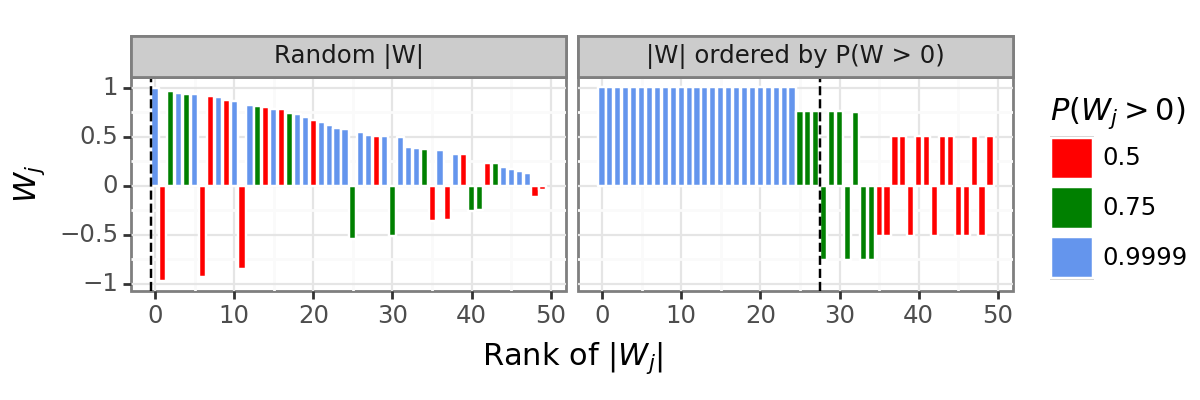

In [161]:
g = (
    ggplot(
        df, aes(x='rank', y='W', fill='probs')
    ) 
    + geom_col(color='white', alpha=1, width=0.9) 
    + facet_wrap("~setting")
    + scale_fill_manual(['red', 'green', 'cornflowerblue'])
    + geom_vline(
        data=tdf,
        mapping=aes(xintercept='ndisc'),
        linetype='dashed',
        color='black'
    )
    + theme_bw()
    + theme(figure_size=(6, 2)) 
    + labs(x=r"Rank of $|W_j|$", y="$W_j$", fill=r"$P(W_j > 0)$")
)
g.save("section2/wstat_plot_synth.png", dpi=500)
print(g)

## 2. Another simulated W-statistic plot (simulated data, not in the final paper)

In [88]:
# Data-generating process
np.random.seed(12345)
p = 100
n = 300
coeff_size = 0.8 # 0.9 is good
sparsity = 0.5 # 0.5 is good

# Correlations

# Option 1: AR1 
rhos = np.random.uniform(0.8, 0.995, size=p-1)
Z = np.random.randn(n, p)
X = Z.copy()
for j in range(1, p):
    X[:, j] = rhos[j-1]*X[:,j-1] + np.sqrt(1-rhos[j-1]**2)*Z[:,j]

    # Option 2: blockdiag
# bsize = 4
# rhos = np.random.uniform(0.8, 0.99, size=int(p/bsize))
# blocks = [
#     rhos[j] * np.ones((bsize,bsize)) + (1-rhos[j]) * np.eye(bsize) for j in range(int(p/bsize))
# ]
# Sigma = scipy.linalg.block_diag(*blocks)
# X = np.random.randn(n, p) @ np.linalg.cholesky(Sigma).T

# beta
beta = knockpy.dgp.create_sparse_coefficients(
    p=p, sparsity=sparsity, coeff_size=coeff_size
)
y = np.random.randn(n) + X @ beta

# Learn S
ksampler = knockpy.knockoffs.FXSampler(X=X, method='MVR')
S = ksampler.fetch_S()

In [89]:
# Three feature statistics
kflsm = KF(ksampler='fx', fstat='lsm')
rejlsm = kflsm.forward(X=X, y=y)
print("Finished with LSM.")
kflcd = KF(ksampler='fx', fstat='lcd')
rejlcd = kflcd.forward(X=X, y=y)
print("Finished with LCD.")
kfMLR = KF(ksampler=ksampler, fstat='mlr')
rejMLR = kfMLR.forward(X=X, y=y)
print("Finished with MLR.")

Finished with LSM.
Finished with LCD.
Finished with MLR.


In [90]:
Wdf = []
Tdf = []
for fstat, kf in zip(
    ['LSM', 'LCD', 'MLR'], 
    [kflsm, kflcd, kfMLR]
):
    norm = np.abs(kf.W.max())
    df = plot_W_path(kf.W / norm, beta=beta)
    df['fstat'] = fstat
    Wdf.append(df)
    Tind = np.argmax(np.abs(df['W'].values) < kf.threshold / norm) - 1
    Tdf.append([fstat, None, Tind])
    
Wdf = pd.concat(Wdf)
Tdf = pd.DataFrame(Tdf, columns=['fstat', 'null', 'rank'])

In [92]:
g = (ggplot(
    Wdf, aes(x='rank', y='W', color='Null', fill='Null')
) + geom_col(width=0.3)
  + facet_grid('~fstat')
  + labs(x='Rank', y=f'$W_j$ (normalized)')#, title='LCD Statistics for MVR and SDP, Equicorrelated Gaussian Designs')
  + geom_vline(
      data = Tdf,
      mapping=aes(xintercept='rank'), linetype='dashed', color='black',
  )
  + guides(
      linetype = None,#guide_legend(title=''),
      fill = guide_legend(title='Null'),
      color = guide_legend(title='Null'),
  )
  + scale_color_manual(values=('cornflowerblue', '#ee2c2c'))
  + scale_fill_manual(values=('cornflowerblue', '#ee2c2c'))
  + theme(figure_size=(6,1.5))
)
#print(g)
#g.save("section2/wstat_plot.png", dpi=500)

### Local dependence plot

Power is 0.42
Maximum off-diagonal element is 0.05641260126012598.
Power is 0.1
Maximum off-diagonal element is 0.024290819081908138.


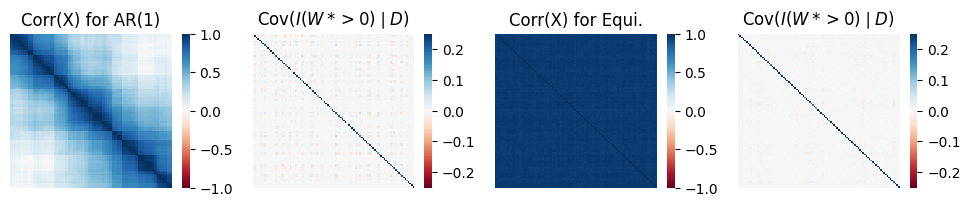

In [45]:
n, p, sparsity = 150, 100, 1.0
coeff_size = 5
coeff_dist = 'uniform'
# data-generating processes
np.random.seed(123)
dgprocess1 = knockpy.dgp.DGP()
dgprocess1.sample_data(
    n=n,
    p=p,
    method='ar1',
    a=50,
    b=1,
    sparsity=sparsity,
    coeff_size=coeff_size,
    coeff_dist=coeff_dist,
)
dgprocess2 = knockpy.dgp.DGP()
dgprocess2.sample_data(
    n=n,
    p=p,
    method='equi',
    block_size=p,
    rho=0.95,
    sparsity=sparsity,
    coeff_size=50*coeff_size,
    coeff_dist=coeff_dist,
)

fig, ax = plt.subplots(1, 4, figsize=(12,2))


for i, dgprocess, cov in zip(
    [0,1], [dgprocess1, dgprocess2], ['AR(1)', 'Equi.']
):
    fstat = knockpy.mlr.MLR_Spikeslab(tau2_a0=2.0, tau2_b0=0.1)
    kf = KF(fstat=fstat, ksampler='gaussian')
    rej = kf.forward(X=dgprocess.X, y=dgprocess.y)
    print(f"Power is {rej.sum() / p}")
    psicov = np.cov(kf.fstat.psis.T)
    print(f"Maximum off-diagonal element is {np.max(np.abs(psicov - np.diag(np.diag(psicov))))}.")
    sns.heatmap(
        psicov, cmap='RdBu', vmin=-0.25, vmax=0.25, ax=ax[2*i+1], 
        yticklabels=False, xticklabels=False
    )
    ax[2*i+1].set(title=rf"Cov($I(W* > 0) \mid D$)")
    sns.heatmap(
        np.corrcoef(dgprocess.X.T), 
        cmap='RdBu',
        xticklabels=False,
        yticklabels=False,
        vmin=-1, vmax=1, ax=ax[2*i]
    )
    ax[2*i].set(title=f"Corr(X) for {cov}")
plt.savefig(f"section3/dependency_combined.png", dpi=500, bbox_inches='tight')
plt.show()

# 2. Main simulation plots

## Gaussian linear models

In [113]:
# dates = ['2022-08-19', '2022-08-19', '2022-08-21']# '2022-08-17']
# times = ['00-49-58', '00-50-43', '16-09-18']
# dfs = []
# for d, t in zip(dates, times):
#     df = pd.read_csv(f"../data/main/{d}/{t}/results.csv")
#     dfs.append(df)}
# all_df = pd.concat(dfs)
all_df = load_data_by_job_id(["1323869", "1328254"])
all_df['mx'] = all_df['mx'].astype(str).map({"True":"MX", "False":"FX"})
# all_df['fstat'] = all_df['fstat'].map({
#     "mlr":'MLR', 
#     "lcd":"LCD", "lsm":"LSM", 
#     "oracle":"MLR\n(oracle)", 
# })
all_df['Knockoff_Type'] = all_df['mx'] + " " + all_df['knockoff_type'].str.upper()
all_df['covmethod'] = all_df['covmethod'].str.lower().map({"ar1":"AR1", "ver":"ErdosRenyi"})


all_df = all_df.loc[
    ((all_df['mx'] != 'MX') |
    (all_df['coeff_size'] == 1.0)) &
    (all_df['n'] > 125)
]
all_df['oracle'] = all_df['fstat'].str.lower().str.contains("oracle")
all_df = all_df.loc[all_df['fstat'] != 'AMLR']

Found 514 files


/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/themes/themeable.py:2438: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


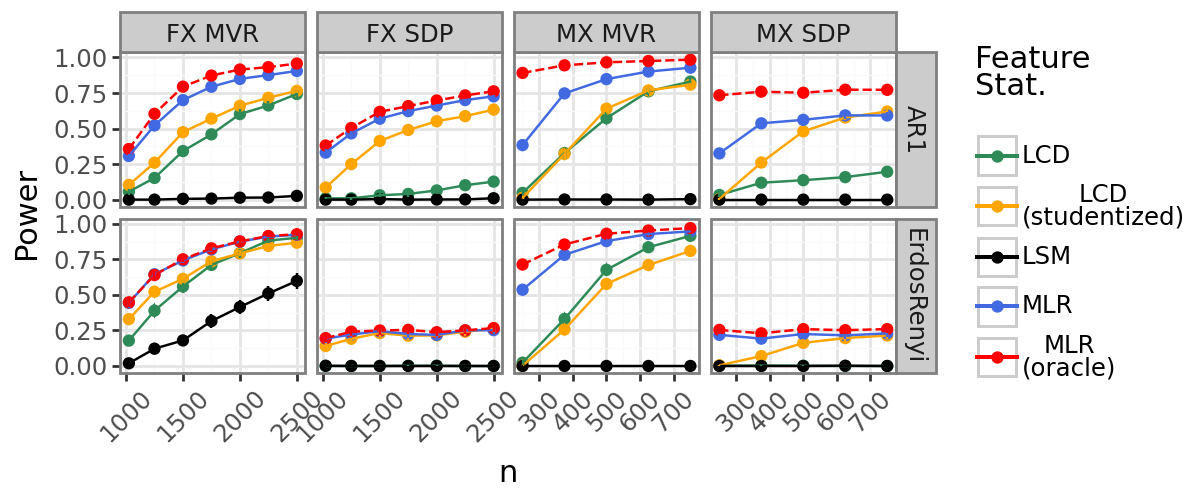

/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: section3/linear_model.png
/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/themes/themeable.py:2438: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


In [115]:
agg_df = calc_mean_sem(
    all_df,
    group_vals=[
        'n', 'p', 'Knockoff_Type', 'fstat', 'q', 
        'coeff_size', 'sparsity', 'covmethod', 'oracle'
    ],
    meas=['power', 'fdp', 'ko_time', 'fstat_time'],
)
meas = 'power'
g = (
    ggplot(
        agg_df.loc[agg_df['q'].isin([0.05])],
        aes(x='n', y=f"{meas}_mean", color='fstat')
    ) + 
    geom_point() +
    geom_line(aes(linetype='oracle')) +
    geom_errorbar(aes(ymin=f"{meas}_ymin", ymax=f"{meas}_ymax")) +
    facet_grid("covmethod~Knockoff_Type", scales='free_x') +
    theme_bw() + 
    theme(
        figure_size=(6,2.5), 
        axis_text_x=element_text(rotation=45), 
        subplots_adjust={'wspace':0.10, 'hspace':0.12},
    ) +
    labs(
        #title="Power for Gaussian linear models", 
        y='Power', x='n', color='Feature\nStat.\n',
    ) +
    scale_color_manual(['seagreen', 'orange', 'black', 'royalblue', 'red']) +
    scale_linetype_discrete(guide=None)
    #scale_color_manual(['blue', 'red', 'orange', 'cornflowerblue'])
)
display(g)
g.save("section3/linear_model.png", dpi=500)
#g += theme(figure_size=(6,4))
#display(g)
#g.save("presentation/section3/linear_model.png", dpi=500)


## Varied sparsity + heavy-tailed coefficients

In [15]:
dates = ['2022-08-19', '2022-08-21'] # ['2022-08-21']
times = ['00-58-30', '10-05-53'] #['11-22-31']
dfs = []
for d, t in zip(dates, times):
    df = pd.read_csv(f"../data/main/{d}/{t}/results.csv")
    dfs.append(df)
all_df = pd.concat(dfs)
all_df['mx'] = all_df['mx'].astype(str).map({"True":"MX", "False":"FX"})
all_df['fstat'] = all_df['fstat'].map({
    "mlr":'MLR', 
    "lcd":"LCD", "lsm":"LSM", 
    "oracle":"MLR*\n(oracle)", 
    "knockoff*":"MLR*\n(oracle)"
})
all_df['covmethod'] = all_df['covmethod'].map({"ar1":"AR1", "ver":"ER"})
all_df['setting'] = all_df['covmethod'] + " (" + all_df['knockoff_type'].str.upper() + ")"
all_df['coeff_dist'] = all_df['coeff_dist'].map({
    "uniform":"Uniform", "expo":"Laplace"
})
all_df['oracle'] = all_df['fstat'].str.contains("oracle")

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


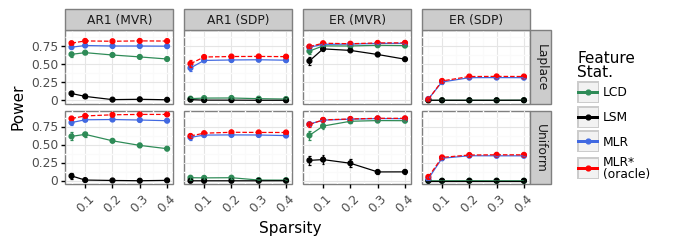

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: section3/vary_sparsity.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

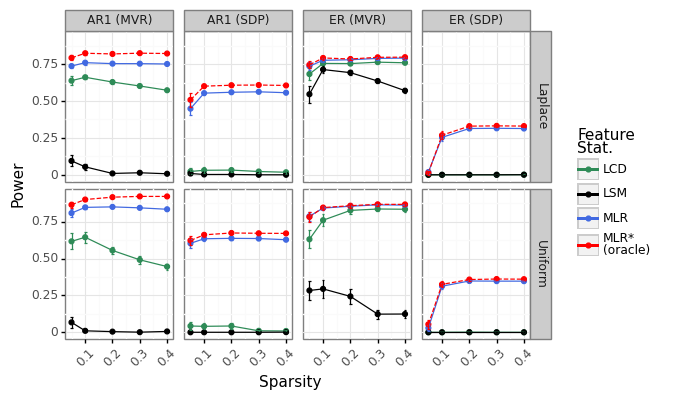

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: presentation/section3/vary_sparsity.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [16]:
agg_df = calc_mean_sem(
    all_df,
    group_vals=[
        'n', 'p', 'setting', 'fstat', 'q', 'oracle',
        'coeff_size', 'sparsity', 'covmethod', 
        'coeff_dist'
    ],
    meas=['power', 'fdp', 'ko_time', 'fstat_time'],
)

meas = 'power'
g = (
    ggplot(
        agg_df.loc[agg_df['q'].isin([0.05])],
        aes(x='sparsity', y=f"{meas}_mean", color='fstat')
    ) + 
    geom_point() +
    geom_line(aes(linetype='oracle')) +
    geom_errorbar(aes(ymin=f"{meas}_ymin", ymax=f"{meas}_ymax"), width=0.01) +
    facet_grid("coeff_dist~setting") +
    theme_bw() + 
    theme(
        figure_size=(6,2), 
        axis_text_x=element_text(rotation=45), 
        subplots_adjust={'wspace':0.10},
    ) +
    labs(
        #title="Power for fixed-X knockoffs with mispecified prior", 
        y='Power', 
        x='Sparsity',
        color='Feature\nStat.\n'
    ) +
    scale_color_manual(['seagreen', 'black', 'royalblue', 'red']) +
    scale_linetype_discrete(guide=False)
    #scale_color_manual(['blue', 'red', 'orange', 'cornflowerblue'])
)
print(g)
g.save("section3/vary_sparsity.png", dpi=500)
g += theme(figure_size=(6,4))
print(g)
g.save("presentation/section3/vary_sparsity.png", dpi=500)


## Varied p and computation time

In [17]:
dates = ['2022-08-21']#'2022-08-19']
times = ['11-23-18']#'02-11-06']
dfs = []
for d, t in zip(dates, times):
    df = pd.read_csv(f"../data/main/{d}/{t}/results.csv")
    dfs.append(df)
all_df = pd.concat(dfs)
all_df['mx'] = all_df['mx'].astype(str).map({"True":"MX", "False":"FX"})
all_df['fstat'] = all_df['fstat'].map({
    "mlr":'MLR', 
    "lcd":"LCD", "lsm":"LSM", 
    "oracle":"Knockoff*\n(oracle)", 
    "knockoff*":"Knockoff*\n(oracle)"
})
all_df['Knockoff_Type'] = all_df['mx'] + " " + all_df['knockoff_type'].str.upper()
all_df['covmethod'] = all_df['covmethod'].map({"ar1":"AR1", "ver":"ErdosRenyi"})

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


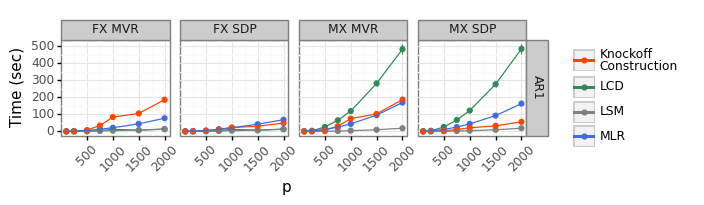

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 1.25 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: section3/vary_p.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

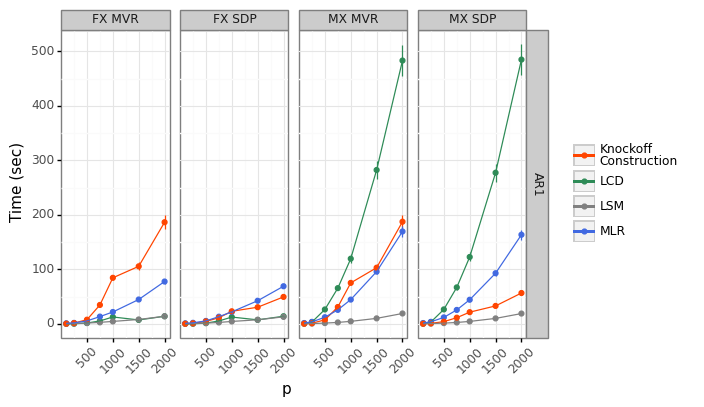

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: presentation/section3/vary_p.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [18]:
agg_df = calc_mean_sem(
    all_df,
    group_vals=[
        'n', 'p', 'Knockoff_Type', 'fstat', 'q', 
        'coeff_size', 'sparsity', 'covmethod'
    ],
    meas=['power', 'fdp', 'ko_time', 'fstat_time'],
)
agg_df = agg_df.loc[~agg_df['fstat'].str.contains('oracle')]

# Create dummy variable for knockoff time
dummy = agg_df.loc[agg_df['fstat'].str.contains('LSM')].copy()
dummy['fstat'] = 'Knockoff\nConstruction'
for suffix in ['mean', 'se', 'ymin', 'ymax']:
    dummy[f'fstat_time_{suffix}'] = dummy[f'ko_time_{suffix}']
agg_df = pd.concat([agg_df, dummy], axis='index')
    
meas = 'fstat_time'
g = (
    ggplot(
        agg_df.loc[agg_df['q'].isin([0.05])],
        aes(x='p', y=f"{meas}_mean", color='fstat')
    ) + 
    geom_point() +
    geom_line() +
    geom_errorbar(aes(ymin=f"{meas}_ymin", ymax=f"{meas}_ymax"), width=0.01) +
    facet_grid("covmethod~Knockoff_Type") +
    theme_bw() + 
    theme(
        figure_size=(6,1.25), 
        axis_text_x=element_text(rotation=45), 
        subplots_adjust={'wspace':0.10},
    ) +
    labs(
        y='Time (sec)', 
        x='p', 
        color=''
    ) +
    #scale_color_manual(['royalblue', 'seagreen', 'black', 'red'])
    scale_color_manual(['orangered', 'seagreen', 'gray', 'royalblue'])
)
print(g)
g.save("section3/vary_p.png", dpi=500)
g += theme(figure_size=(6,4))
print(g)
g.save("presentation/section3/vary_p.png", dpi=500)

## Nonlinear

In [20]:
dates = ['2022-08-19', '2022-08-19', '2022-08-19', '2022-08-21']# '2022-08-17']
times = ['01-26-22', '14-47-22', '14-52-21', '16-07-18']
dfs = []
for d, t in zip(dates, times):
    df = pd.read_csv(f"../data/main/{d}/{t}/results.csv")
    dfs.append(df)
all_df = pd.concat(dfs)
# all_df['fstat'] = all_df['fstat'].map({
#     "mlr":'MLR', 
#     "lcd":"LCD", "lsm":"LSM", 
#     "oracle":"Knockoff*\n(oracle)", 
#     "knockoff*":"Knockoff*\n(oracle)"
# })
all_df['knockoff_type'] = all_df['knockoff_type'].str.upper()
all_df['covmethod'] = all_df['covmethod'].map({"ar1":"AR1", "ver":"ErdosRenyi"})
all_df = all_df.loc[all_df['cond_mean'] != 'pairint']
all_df['cond_mean'] = all_df['cond_mean'].map({
    "cos":"$\cos$", 
    "sin":"$\sin$", 
    "cubic":"cubic", 
    "quadratic":"quadratic",
})
all_df['fstat'] = all_df['fstat'].map({
    "lcd":"LCD", 
    "mlr":"MLR (linear)", 
    "mlr_spline":"MLR (splines)", 
    "deeppink":"DeepPINK",
    "randomforest":"Random\nForest",
    "oracle":"MLR (oracle)"
})
all_df['oracle'] = all_df['fstat'].str.contains("oracle")

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


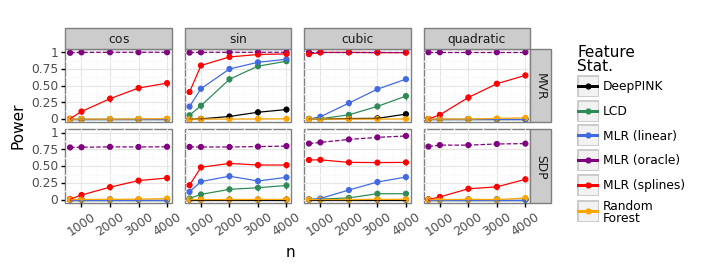

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: section3/nonlinear_model_q0.05.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from

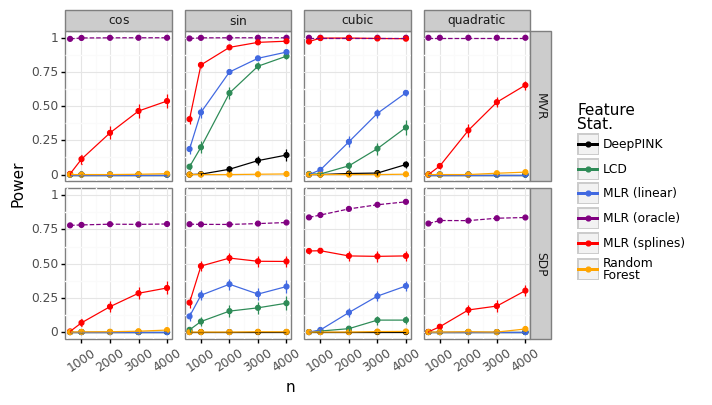

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: presentation/section3/nonlinear_model_q0.05.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be

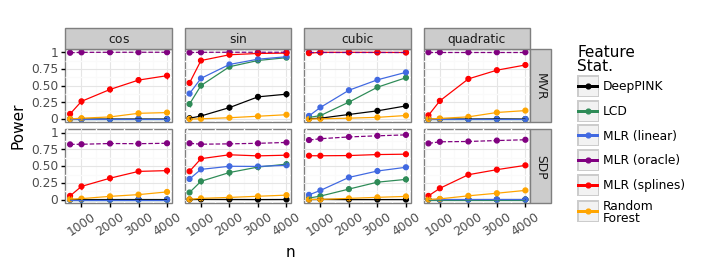

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: section3/nonlinear_model_q0.1.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from 

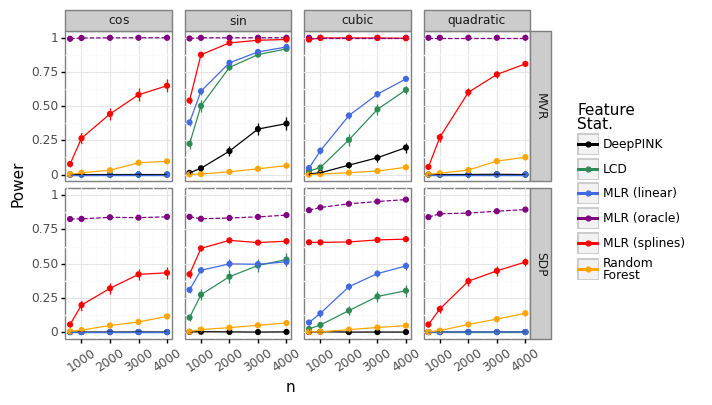

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: presentation/section3/nonlinear_model_q0.1.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [21]:
agg_df = calc_mean_sem(
    all_df,
    group_vals=[
        'n', 'p', 'knockoff_type', 'fstat', 'q', 'oracle',
        'coeff_size', 'sparsity', 'covmethod', 'cond_mean'
    ],
    meas=['power', 'fdp', 'ko_time', 'fstat_time'],
)
agg_df['q_eq'] = agg_df['q'].apply(lambda x: "q="+str(x))

meas = 'power'
for q in [0.05, 0.1]:
    g = (
        ggplot(
            agg_df.loc[agg_df['q'].isin([q])],
            aes(x='n', y=f"{meas}_mean", color='fstat')
        ) + 
        geom_point() +
        geom_line(aes(linetype='oracle')) +
        geom_errorbar(aes(ymin=f"{meas}_ymin", ymax=f"{meas}_ymax")) +
        #facet_grid("q_eq+knockoff_type~cond_mean", scales='fixed') +
        facet_grid("knockoff_type~cond_mean", scales='fixed') +
        theme_bw() + 
        theme(
            figure_size=(6, 2), 
            axis_text_x=element_text(rotation=34), 
            subplots_adjust={'wspace':0.12},
        ) +
        labs(
            y='Power', x='n', color='Feature\nStat.\n'
        ) +
        scale_color_manual(['black', 'seagreen', 'royalblue', 'purple', 'red', 'orange']) +
        scale_linetype_discrete(guide=False)
        #scale_color_manual(['blue', 'red', 'orange', 'cornflowerblue'])
    )
    print(g)
    g.save(f"section3/nonlinear_model_q{q}.png", dpi=500)
    g += theme(figure_size=(6,4))
    print(g)
    g.save(f"presentation/section3/nonlinear_model_q{q}.png", dpi=500)


### Binary y

In [276]:
dates = ['2022-08-21', '2022-08-21']# '2022-08-17']
times = ['19-00-22', '19-00-35']
dfs = []
for d, t in zip(dates, times):
    df = pd.read_csv(f"../data/main/{d}/{t}/results.csv")
    dfs.append(df)
all_df = pd.concat(dfs)
all_df['mx'] = all_df['mx'].astype(str).map({"True":"MX", "False":"FX"})
all_df['fstat'] = all_df['fstat'].map({
    "mlr":'MLR', 
    "lcd":"LCD", "lsm":"LSM", 
    "oracle":"MLR\n(oracle)", 
})
all_df['covmethod'] = all_df['covmethod'].map({"ar1":"AR1", "ver":"ER"})
all_df['Knockoff_Type'] = all_df['covmethod'] + " (" + all_df['knockoff_type'].str.upper() + ")"


all_df = all_df.loc[
    ((all_df['mx'] != 'MX') |
    (all_df['coeff_size'] == 1.0)) &
    (all_df['n'] > 125)
]
all_df['oracle'] = all_df['fstat'].str.contains("oracle")

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


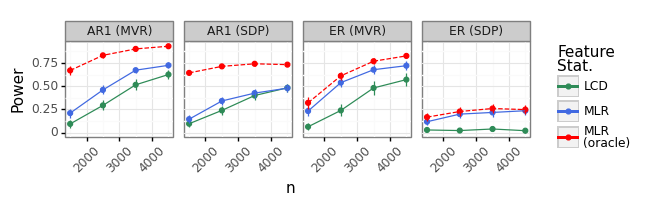

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 1.25 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: section3/logistic_model.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [277]:
agg_df = calc_mean_sem(
    all_df,
    group_vals=[
        'n', 'p', 'Knockoff_Type', 'fstat', 'q', 
        'coeff_size', 'sparsity', 'covmethod', 'oracle'
    ],
    meas=['power', 'fdp', 'ko_time', 'fstat_time'],
)

meas = 'power'
g = (
    ggplot(
        agg_df.loc[agg_df['q'].isin([0.05])],
        aes(x='n', y=f"{meas}_mean", color='fstat')
    ) + 
    geom_point() +
    geom_line(aes(linetype='oracle')) +
    geom_errorbar(aes(ymin=f"{meas}_ymin", ymax=f"{meas}_ymax")) +
    facet_grid("~Knockoff_Type", scales='free_x') +
    theme_bw() + 
    theme(
        figure_size=(6,1.25), 
        axis_text_x=element_text(rotation=45), 
        subplots_adjust={'wspace':0.10, 'hspace':0.12},
    ) +
    labs(
        y='Power', x='n', color='Feature\nStat.\n',
    ) +
    scale_color_manual(['seagreen', 'royalblue', 'red']) +
    scale_linetype_discrete(guide=False)
)
print(g)
g.save("section3/logistic_model.png", dpi=500)


## MLR vs. AMLR

In [6]:
dates = ['2024-08-27', '2024-08-28']# '2022-08-17']
times = ['21-44-38', '10-19-22']
dfs = []
for d, t in zip(dates, times):
    df = pd.read_csv(f"../data/main/{d}/{t}/results.csv")
    dfs.append(df)
all_df = pd.concat(dfs)
all_df = all_df.loc[all_df['fstat'].isin(['mlr', 'amlr'])]
all_df['mx'] = all_df['mx'].astype(str).map({"True":"MX", "False":"FX"})
all_df['fstat'] = all_df['fstat'].map({
    "mlr":'MLR', 
    "amlr":"AMLR", 
})
all_df['qval'] = all_df['q'].copy()
all_df['q'] = all_df['q'].apply(lambda x: f"q={x}")

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: section3/amlr.png
/tmp/ipykernel_5550/1078032427.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


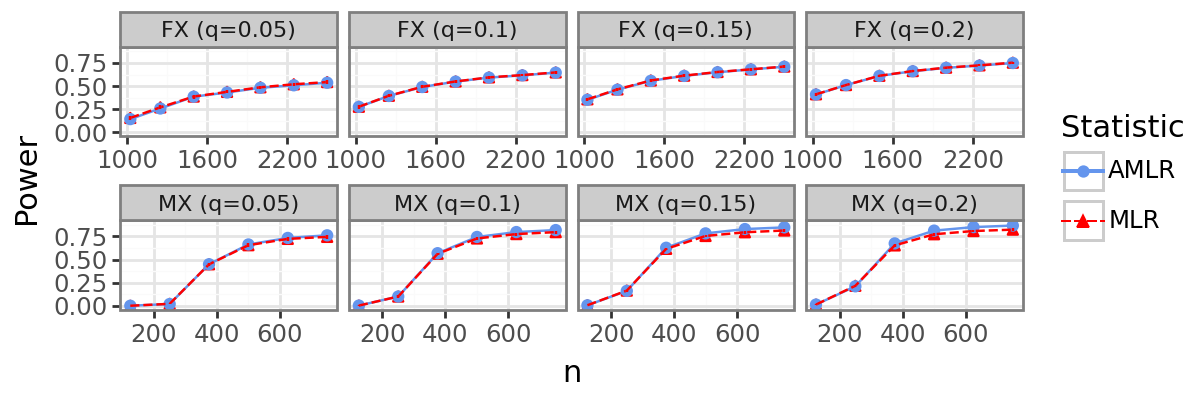

In [22]:
agg = calc_mean_sem(
    all_df,
    group_vals=['n', 'q', 'coeff_size', 'sparsity', 'mx', 'fstat'],
    meas=['power']
)
agg['mx'] = pd.Categorical(agg['mx'], ordered=True, categories=['MX', 'FX'])
agg['facet'] = agg['q'].astype(str) + ' (' + agg['mx'].astype(str) + ")"
agg['facet2'] = agg['mx'].astype(str) + " (" + agg['q'].astype(str) + ")"
g = (
    ggplot(agg, aes(x='n', y='power_mean', color='fstat', shape='fstat', linetype='fstat'))
    + geom_point()
    + geom_line()
    + geom_errorbar(aes(ymin='power_ymin', ymax='power_ymax'), width=0.1)
    + facet_wrap("~facet2", scales='free_x', ncol=4, labeller='label_value', dir='h')
    #+ facet_wrap("~mx+q", scales='free_x', ncol=4, labeller='label_value', dir='v')
    # + facet_grid(rows="mx", cols='q', scales='free')
    + theme_bw()
    + theme(figure_size=(6, 2), panel_spacing_x=0.01)
    + theme(strip_text_x = element_text(size = 8))
    + scale_x_continuous(breaks=[200, 400, 600, 1000, 1600, 2200])
    + scale_color_manual(['cornflowerblue', 'red'])
    + labs(y='Power', color='Statistic', shape='Statistic', linetype='Statistic')
)
g.save("section3/amlr.png", dpi=500, bbox_inches='tight')
print(g)

# Revision simulations

## Group knockoffs

In [7]:
#data = load_data_by_job_id([1181254])
data = load_data_by_job_id(["1324752", "1335801"])
data = data.loc[data['q'] == 0.05]

Found 369 files


In [8]:
meas_cols = ['power', 'fdp', 'fstat_time', 'ko_time', 'ngroups']
group_cols = [x for x in data.columns if (x not in meas_cols and x != 'seed')]
agg = calc_mean_sem(
    data=data,
    group_vals=group_cols,
    meas=meas_cols,
)

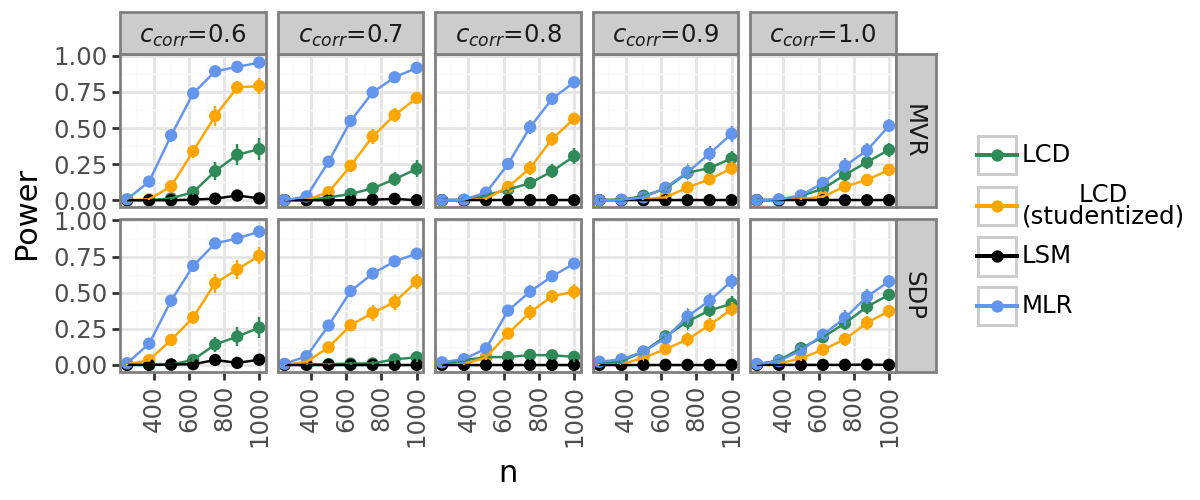

/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: section3/groupknock.png


In [9]:
agg['ccutoff'] = agg['correlation_cutoff'].apply(
    lambda x: r'$c_{corr}$=' + str(x)
)
agg['nn'] = agg['n'].apply(lambda x: r'$n$=' + str(x))
g = (
    ggplot(
        agg,
        aes(x='n', y='power_mean', color='fstat')
    )
    + facet_grid("knockoff_type~ccutoff")
    + geom_point()
    + geom_line()
    + geom_errorbar(aes(ymin='power_ymin', ymax='power_ymax'))
    + labs(x='n', y='Power', color='')
    + scale_color_manual(['seagreen', 'orange', 'black', 'cornflowerblue'])
    + theme_bw() + theme(figure_size=(6, 2.5))
    + theme(axis_text_x=element_text(angle=90))
)
display(g)
g.save("section3/groupknock.png", dpi=500)


## Computational efficiency

In [81]:
data.loc[(data['n'] == 5000) & (data['p'] == 5000)]

,p,n,seed,mlr_time,lasso_time,lasso_cv_time,susie_time
0,5000,5000,4,9.431254,1.746460,99.509542,83.175811
1,5000,5000,5,8.221376,1.871463,96.161335,52.833114
2,5000,5000,6,8.160061,1.690449,85.716378,58.674941
0,5000,5000,7,8.960276,1.745511,101.911992,60.113837
1,5000,5000,8,8.115267,1.802370,100.792622,50.941654
2,5000,5000,9,7.855609,1.746275,88.402281,88.693612
0,5000,5000,1,8.705576,1.747130,102.962462,60.604800
1,5000,5000,2,8.204652,1.859133,99.956838,62.447858
2,5000,5000,3,7.950422,1.711686,85.617383,64.795485


Found 16 files


/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


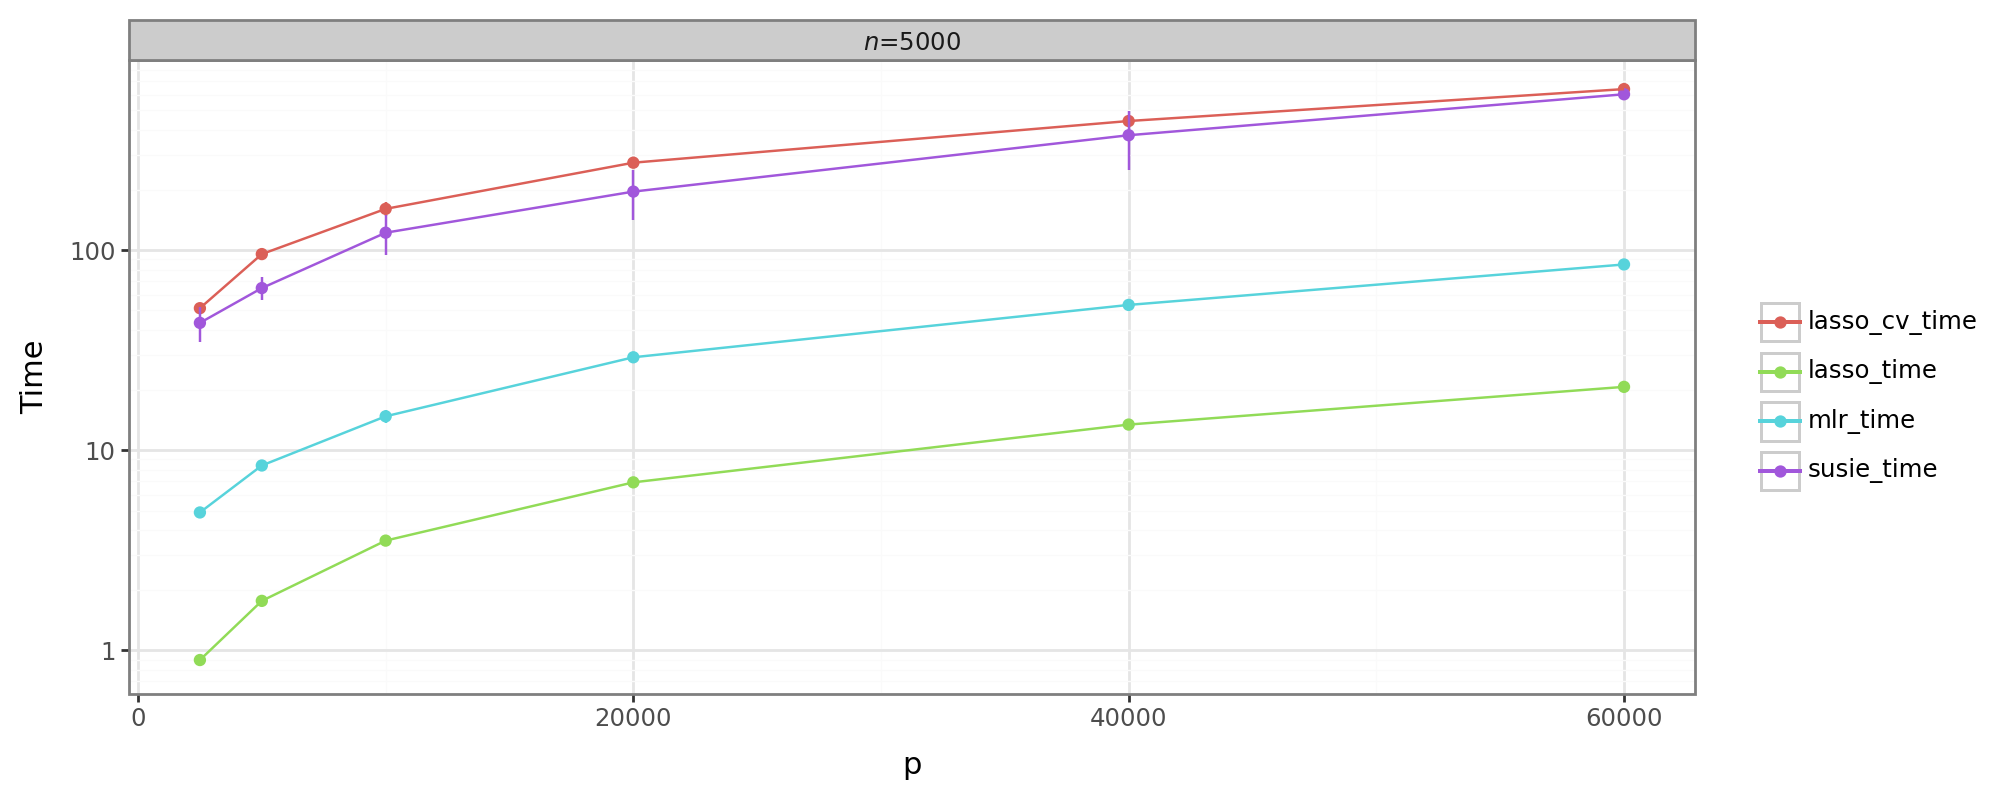

In [82]:
data = load_data_by_job_id(["26155979"]) # new
#data = load_data_by_job_id(["25899757"]) # old
mdata = pd.melt(
    data,
    id_vars=['n', 'p'],
    value_vars=['mlr_time', 'lasso_time', 'lasso_cv_time', 'susie_time'],
)
agg = calc_mean_sem(
    data=mdata,
    group_vals=['n', 'p', 'variable'],
    meas=['value'],
)
g = (
    ggplot(
        agg,
        aes(x='p', y='value_mean', color='variable')
    )
    + facet_wrap("~n", scales='free', labeller=labeller(n=lambda x: r'$n$=' + str(x)))
    + geom_point()
    + geom_line()
    + geom_errorbar(aes(ymin='value_ymin', ymax='value_ymax'))
    + labs(x='p', y='Time', color='')
    + theme_bw() 
    + theme(figure_size=(10, 4))
    #+ theme(axis_text_x=element_text(angle=90))
    + scale_y_log10()
)
display(g)
#g.save("section3/largescale_time.png", dpi=500)

In [67]:
agg['value_count'].sum()

np.int64(92)

In [64]:
agg.loc[agg['value_count'] > 0].sort_values('value_count')

,n,p,variable,value_mean,value_se,value_count,value_ymin,value_ymax
12,5000,20000,lasso_cv_time,281.153081,1.444964,2,278.263152,284.043010
13,5000,20000,lasso_time,7.128317,0.029379,2,7.069559,7.187076
14,5000,20000,mlr_time,29.122517,0.283073,2,28.556371,29.688663
15,5000,20000,susie_time,190.448625,22.356078,2,145.736469,235.160782
8,5000,10000,lasso_cv_time,184.508252,2.281474,3,179.945304,189.071200
9,5000,10000,lasso_time,3.744849,0.046632,3,3.651586,3.838112
10,5000,10000,mlr_time,16.700178,0.796460,3,15.107259,18.293097
11,5000,10000,susie_time,130.129503,28.877763,3,72.373978,187.885028
7,5000,5000,susie_time,64.697901,4.292031,9,56.113839,73.281963
6,5000,5000,mlr_time,8.400499,0.173924,9,8.052652,8.748347


## Robustness

In [87]:
data = load_data_by_job_id([1179287, 1180224, 1315894])
data = data.loc[data['q'] == 0.05]

def correct_coeff_size(row):
    if 'ar1' in str(row['covmethod']).lower():
        return 0.5
    else:
        return 0.25

data = data.loc[data['coeff_size'] == data.apply(correct_coeff_size, axis=1)]

Found 768 files


In [88]:
meas_cols = ['power', 'fdp', 'fstat_time', 'ko_time', 'ngroups']
group_cols = [x for x in data.columns if (x not in meas_cols and x != 'seed')]
mdata = pd.melt(
    data[group_cols + ['power', 'fdp']],
    id_vars=group_cols,
    var_name='meas',
)
melted_agg = calc_mean_sem(
    mdata,
    meas=['value'],
    group_vals=group_cols + ['meas'],
    
)
# renaming
melted_agg['meas'] = melted_agg['meas'].map({"fdp":"FDR", "power":"Power"})
melted_agg['knockoff_type'] = melted_agg['knockoff_type'].apply(lambda x: str(x).upper())
melted_agg['covmethod'] = melted_agg['covmethod'].apply(lambda x: str(x).upper() + " cov.")

display(melted_agg)

,n,p,knockoff_type,fstat,q,covmethod,sparsity,correlation_cutoff,estimate_sigma,coeff_size,meas,value_mean,value_se,value_ymin,value_ymax
0,125,500,MVR,LCD,0.05,AR1 cov.,0.1,1,True,0.50,FDR,0.000000,0.000000,0.000000,0.000000
1,125,500,MVR,LCD,0.05,AR1 cov.,0.1,1,True,0.50,Power,0.000000,0.000000,0.000000,0.000000
2,125,500,MVR,LCD,0.05,VER cov.,0.1,1,True,0.25,FDR,0.000000,0.000000,0.000000,0.000000
3,125,500,MVR,LCD,0.05,VER cov.,0.1,1,True,0.25,Power,0.000000,0.000000,0.000000,0.000000
4,125,500,MVR,LCD\n(studentized),0.05,AR1 cov.,0.1,1,True,0.50,FDR,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,750,500,SDP,LSM,0.05,VER cov.,0.1,1,True,0.25,Power,0.758008,0.011187,0.735633,0.780382
348,750,500,SDP,MLR,0.05,AR1 cov.,0.1,1,True,0.50,FDR,0.103841,0.004413,0.095016,0.112666
349,750,500,SDP,MLR,0.05,AR1 cov.,0.1,1,True,0.50,Power,0.921719,0.003665,0.914389,0.929049
350,750,500,SDP,MLR,0.05,VER cov.,0.1,1,True,0.25,FDR,0.034930,0.001672,0.031587,0.038274


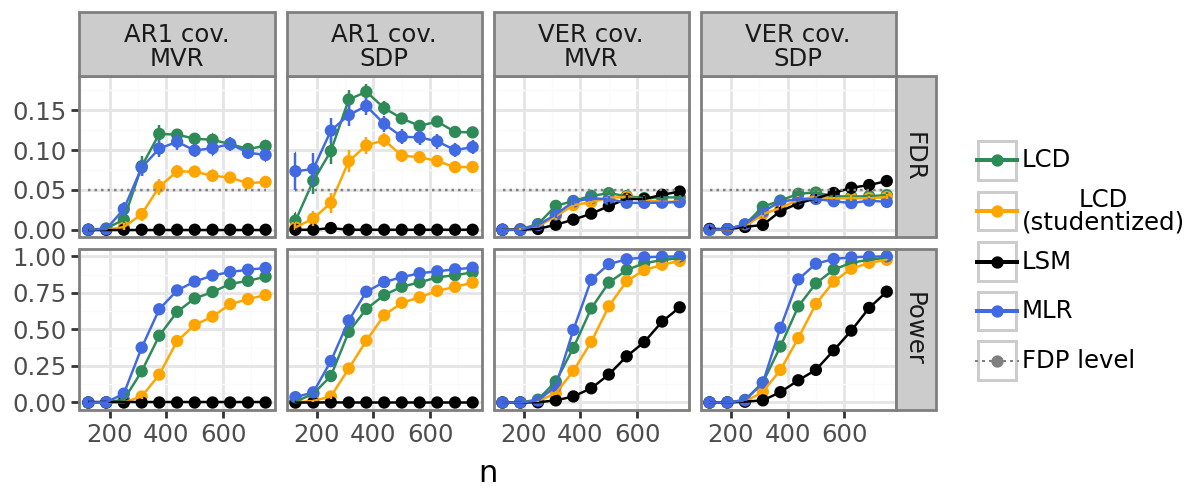

/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: section3/robustness.png


In [94]:
# xeqy
xeqy = melted_agg.loc[
    (melted_agg['meas'] == 'FDR') & 
    (melted_agg['fstat'] == 'LCD')
].copy()
xeqy['fstat'] = 'FDP level'
xeqy['value_mean'] = 0.05
xeqy['value_ymax'] = 0.05
xeqy['value_ymin'] = 0.05
to_plot = pd.concat([melted_agg, xeqy])
# plotting
g = (
    ggplot(
        melted_agg,
        aes(x='n', y='value_mean', color='fstat', linetype='fstat')
    ) 
    + facet_grid("meas~covmethod+knockoff_type", scales='free_y') 
    + geom_point()
    + geom_line()
    + geom_line(data=xeqy)
    + theme_bw()
    + theme(figure_size=(6,2.5))
    + scale_color_manual(['seagreen', 'orange', 'black', 'royalblue', 'gray'])
    + scale_linetype_manual(['solid', 'solid', 'solid', 'solid', 'dotted'])
    + geom_errorbar(aes(ymin='value_ymin', ymax='value_ymax'))
    + labs(
        x='n', y='', color='', linetype=''
    )

)
display(g)
g.save("section3/robustness.png", dpi=500)


## Misc

In [17]:
import glob
#jobid = 1176428 # robustness
#jobid = 1176425 # groupknock
#jobid = 1181254 # groupknock next iteration, looks good except power decreases as cutoff increases
#jobids = [1179287, 1180224] # robustness -- looks good
#jobid = 1180224
jobid = 0 # main -- hopefully final

files = glob.glob(f"../data/sims_main/**/jobid{jobid}*.csv", recursive=True)
print(len(files))
data = []
for f in files:
    data.append(pd.read_csv(f))

df = pd.concat(data)
df = df.loc[df['q'] == 0.05]
df.columns

5


Index(['n', 'p', 'covmethod', 'sparsity', 'coeff_size', 'coeff_dist', 'seed',
       'cond_mean', 'y_dist', 'mx', 'knockoff_type', 'fstat', 'q', 'power',
       'fdp', 'fstat_time', 'ko_time'],
      dtype='object')

,n,p,covmethod,sparsity,coeff_size,coeff_dist,cond_mean,y_dist,mx,knockoff_type,...,fdp_ymin,fdp_ymax,fstat_time_mean,fstat_time_se,fstat_time_ymin,fstat_time_ymax,ko_time_mean,ko_time_se,ko_time_ymin,ko_time_ymax
0,40,20,AR1,0.1,1,uniform,linear,gaussian,True,mvr,...,0.0,0.000000,0.654821,0.211228,0.232366,1.077277,0.025000,0.005000,0.015000,0.03500
1,40,20,AR1,0.1,1,uniform,linear,gaussian,True,mvr,...,0.0,0.000000,0.035932,0.013260,0.009412,0.062451,0.025000,0.005000,0.015000,0.03500
2,40,20,AR1,0.1,1,uniform,linear,gaussian,True,mvr,...,0.0,0.000000,0.841177,0.301261,0.238656,1.443698,0.025000,0.005000,0.015000,0.03500
3,40,20,AR1,0.1,1,uniform,linear,gaussian,True,mvr,...,0.0,0.000000,0.023611,0.008136,0.007338,0.039884,0.025000,0.005000,0.015000,0.03500
4,40,20,AR1,0.1,1,uniform,linear,gaussian,True,mvr,...,0.0,0.000000,0.654821,0.211228,0.232366,1.077277,0.025000,0.005000,0.015000,0.03500
5,40,20,AR1,0.1,1,uniform,linear,gaussian,True,mvr,...,0.0,0.000000,0.024733,0.002094,0.020545,0.028922,0.025000,0.005000,0.015000,0.03500
6,40,20,AR1,0.1,1,uniform,linear,gaussian,True,sdp,...,0.0,0.000000,0.428882,0.022941,0.383000,0.474765,0.025000,0.015000,0.000000,0.05500
7,40,20,AR1,0.1,1,uniform,linear,gaussian,True,sdp,...,0.0,0.000000,0.050372,0.001115,0.048141,0.052602,0.025000,0.015000,0.000000,0.05500
8,40,20,AR1,0.1,1,uniform,linear,gaussian,True,sdp,...,0.0,0.000000,0.945752,0.161896,0.621960,1.269544,0.025000,0.015000,0.000000,0.05500
9,40,20,AR1,0.1,1,uniform,linear,gaussian,True,sdp,...,0.0,0.000000,0.023838,0.001003,0.021832,0.025845,0.025000,0.015000,0.000000,0.05500


/home/asher/Documents/Research/emmanuel/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


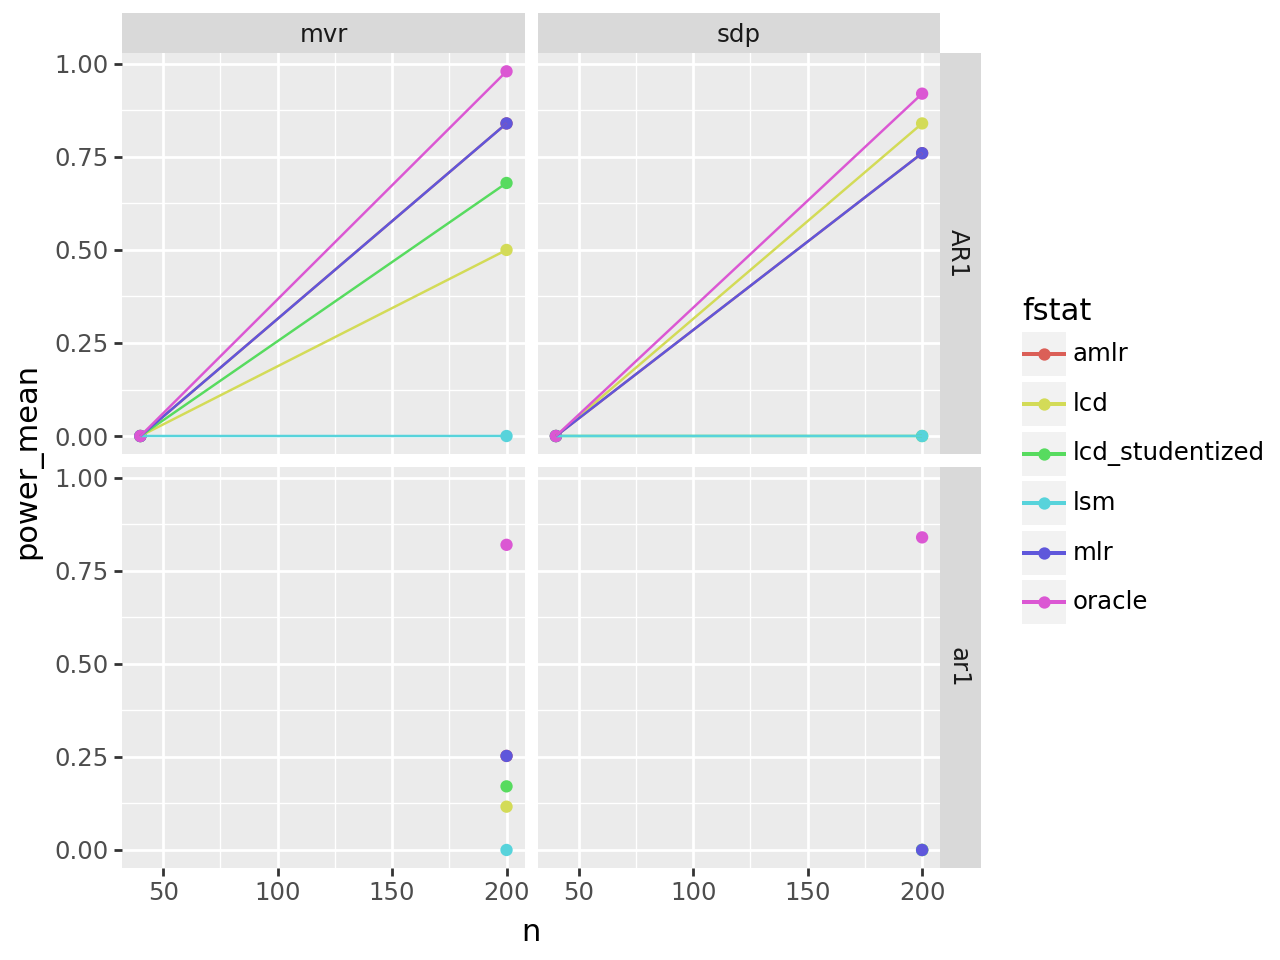

In [18]:
meas_cols = ['power', 'fdp', 'fstat_time', 'ko_time', 'ngroups']
meas_cols = [x for x in df.columns if x in meas_cols]
group_cols = [x for x in df.columns if (x not in meas_cols and x != 'seed')]
agg = calc_mean_sem(
    df, 
    group_vals=group_cols,
    meas=meas_cols
)
display(agg)
##robustness
ggplot(
    agg,
    aes(x='n', y='power_mean', color='fstat')
) + facet_grid("covmethod~knockoff_type") + geom_point() + geom_line()
## groupknock
# ggplot(
#     agg,
#     aes(x='n', y='power_mean', color='fstat')
# ) + facet_grid("correlation_cutoff~knockoff_type") + geom_point() + geom_line()

# Real data applications

## HIV data

/tmp/ipykernel_7251/3487196643.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: section4/hiv_application.png


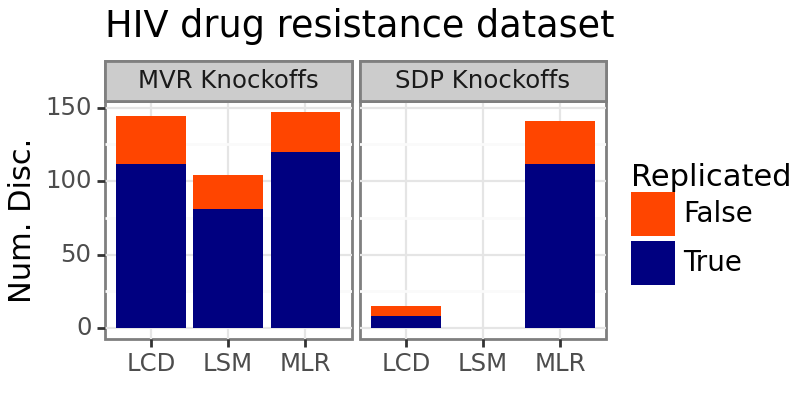

In [199]:
# read data
rej = pd.read_csv(f"../real_data/hiv_data/results/num_rej.csv")
rej['S_method'] = rej['S_method'].str.upper()
rej['fstat'] = rej['fstat'].str.upper()
rej = rej.loc[~rej['S_method'].str.contains("EQUI")]#, 'S_method'] = 'EQUI'
# melt
rej = rej.drop("ndisc", axis='columns')
rej = pd.melt(
    rej, 
    id_vars=['fstat', 'S_method', 'drug_type', 'resistance'],
    var_name='true',
    value_name='ndisc'
)
rej['true'] = pd.Categorical(rej['true'].str.contains('true'))


# Summary statistics
trej = rej.groupby(['fstat', 'S_method', 'true'])['ndisc'].sum().reset_index()
trej['S_method'] = trej['S_method'] + " Knockoffs"

g = (
    ggplot(trej, aes(x='fstat', y='ndisc', fill='true'))
    + geom_col(position='stack')
    + facet_wrap("~S_method")#, labeller='label_both')
    + scale_fill_manual(['orangered', 'navy', 'cornflowerblue'])
    + theme_bw()
    + theme(
        figure_size=(4,2),
        legend_text=element_text(size=10),
        legend_title=element_text(size=11),
    )
    + labs(
        x='',#'Feature Statistic',
        fill='Replicated',
        y='Num. Disc.', 
        title=f"HIV drug resistance dataset"
    )
)
g.save(f"section4/hiv_application.png", dpi=500)
print(g)

### Section 2 plot from HIV data

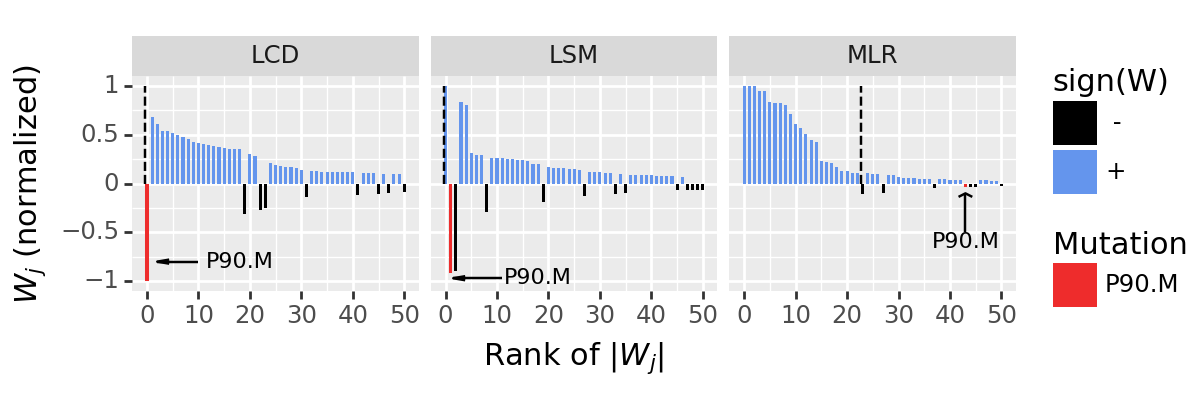

In [329]:
drug_type = 'PI'
drug = 'IDV'

Wdf = pd.read_csv("../real_data/hiv_data/results/W_sorted.csv")
Wdf = Wdf.loc[(Wdf['drug'] == drug) & (Wdf['knockoff_type'] == 'sdp')]
Wdf['sign(W)'] = (Wdf['W'] > 0).apply(lambda x: '+' if x else ' -')
W90M = Wdf.loc[Wdf['name'] == 'P90.M'].copy()
# Wdf['sign(W)'] = Wdf['sign(W)'].map(
#     {"+":r"$W_j$ > 0", " -":r"$W_j$ < 0"}
# )
# Wdf.loc[Wdf['name'] == 'P90.M', 'sign(W)'] = 'P90.M'
# Thresholds for plotting
Tdf = compute_Tdf(Wdf, fdr=0.05)

arrows = pd.DataFrame(columns=['rank', 'W', 'fstat'])
arrows['rank'] = [10, 2, 11, 1.5, 43, 43]
arrows['W'] = [-0.8, -0.8, -0.97, -0.97, -0.5, -0.1]
arrows['fstat'] = ['LCD', 'LCD', 'LSM', 'LSM', 'MLR', 'MLR']
arrows['sign(W)'] = ' -'

text_data = pd.DataFrame(columns=['rank', 'W', 'fstat'])
text_data['rank'] = [18, 18, 43]
text_data['W'] = [-0.8, -0.97, -0.6]
text_data['fstat'] = ['LCD', 'LSM', 'MLR']
text_data['text'] = ['P90.M', 'P90.M', 'P90.M']
text_data['sign(W)'] = ' -'


COLWIDTH = 0.6
red = '#ee2c2c'

g = (ggplot(
    Wdf[Wdf['rank'] <= 50], aes(x='rank', y='W', fill='sign(W)')
) + geom_col(width=COLWIDTH)
  + geom_segment(
      data = Tdf,
      mapping=aes(
          x='rank',
          xend='rank',
          y=0.0,
          yend=1.0,
          inherit_aes=False,
      ), 
      linetype='dashed', color='black',
  )
  + geom_path(
    data=arrows,
      arrow=arrow(length=0.07),
  )
  + geom_text(
    data=text_data,
    mapping=aes(label='text'),
    size=8
  )
  + geom_col(
      data=W90M, 
      mapping=aes(x='rank', y='W', color='name'),
      fill=red,
      inherit_aes=False,
      width=COLWIDTH,
      size=0.01,
    )
  + facet_grid('~fstat')
  + labs(x=f'Rank of $|W_j|$', y=f'$W_j$ (normalized)')#, title='LCD Statistics for MVR and SDP, Equicorrelated Gaussian Designs')
  + guides(
      linetype = None,
      #guide_legend(title=''),
      fill = guide_legend(title='sign(W)'),
      color = guide_legend(title='Mutation'),
  )
  #+ scale_fill_manual(values=('gray', 'cornflowerblue', '#ee2c2c')) # red = '#ee2c2c'
  + scale_fill_manual(values=('black', 'cornflowerblue', '#ee2c2c')) # red = '#ee2c2c'
  #+ scale_color_manual(values=(red))
  + theme(figure_size=(6,2))
)
print(g)
#g.save("section2/wstat_plot_hiv.png", dpi=500)
#g.save("presentation/section2/wstat_plot_hiv.png", dpi=500)

In [200]:
import time; t0 = time.time()
drug_type = 'PI'
col = 'IDV' # APV or IDV
q = 0.05
S_method = 'sdp'

mutations = pd.read_csv(f"../real_data/hiv_data/{drug_type}_mutations.csv")
mutations = mutations.drop("Unnamed: 0", axis='columns')
resistances = pd.read_csv(f"../real_data/hiv_data/{drug_type}_resistances.csv")
resistances = resistances.drop("Unnamed: 0", axis='columns')

# Load y-data
ycol = resistances[col]
X = mutations.loc[ycol.notnull()].copy()
y = np.log(ycol[ycol.notnull()].values)
y = (y - y.mean()) / y.std()
X = X[X.columns[X.sum(axis=0) >= 3]]

# Remove duplicated columns
duplicates = get_duplicate_columns(X.values)
to_keep = [j for j in range(X.shape[1]) if j not in duplicates]
Xcols = X.columns[to_keep]
X = X[Xcols].values
X = X.astype(float)
X = (X - X.mean(axis=0)) / X.std(axis=0) # subtracting the mean makes some difference
n, p = X.shape
if n < 2*p:
    X, y = augment_X_y(X, y)
    
idd = f"drug_type={drug_type}, resistance={col}, S_method={S_method}"
print(f"Starting {idd} at {elapsed(t0)}.")
np.random.seed(12345)
ksampler = knockpy.knockoffs.FXSampler(
    X=X, method=S_method, tol=1e-3 if S_method=='sdp' else 1e-5
)
ksampler.sample_knockoffs()
print(f"Finished sampling knockoffs for {idd} at {elapsed(t0)}.")
kfilter = KF(fstat='mlr', ksampler=ksampler)
rej_mlr = kfilter.forward(
    X=X, 
    y=y, 
    fdr=q, 
    fstat_kwargs={"n_iter":2000, "chains":5}#, "tau2_a0":2, "tau2_b0":0.01}
)
print(f"Finished fitting MLR statistic for {idd} at {elapsed(t0)}.")
kfilter_lcd = KF(fstat='lcd', ksampler=ksampler)
rej_lcd = kfilter_lcd.forward(X=X, y=y, fdr=q)
print(f"Finished fitting LCD statistic for {idd} at {elapsed(t0)}.")
kfilter_lsm = KF(fstat='lsm', ksampler=ksampler)
rej_lsm = kfilter_lsm.forward(X=X, y=y, fdr=q)
print(f"Finished fitting LSM statistic for {idd} at {elapsed(t0)}.")

# Analyze orderings
lsm_order = np.argsort(-1*np.abs(kfilter_lsm.W))
lcd_order = np.argsort(-1*np.abs(kfilter_lcd.W))
mlr_order = np.argsort(-1*np.abs(kfilter.W))
print(lsm_order[0:10], "lsm")
print(lcd_order[0:10], "lcd")
print(mlr_order[0:10], "mlr")
print("LCD correlations:")
for j in lcd_order[0:10]:
    print(kfilter.Xk[:, j] @ kfilter.X[:, j] / np.power(kfilter.X[:, j], 2).sum())
print("MLR correlations:")
for j in mlr_order[0:10]:
    print(kfilter.Xk[:, j] @ kfilter.X[:, j] / np.power(kfilter.X[:, j], 2).sum())
print(Xcols[115])

Starting drug_type=PI, resistance=IDV, S_method=sdp at 0.05.
Finished sampling knockoffs for drug_type=PI, resistance=IDV, S_method=sdp at 1.54.
Finished fitting MLR statistic for drug_type=PI, resistance=IDV, S_method=sdp at 7.49.
Finished fitting LCD statistic for drug_type=PI, resistance=IDV, S_method=sdp at 7.88.
Finished fitting LSM statistic for drug_type=PI, resistance=IDV, S_method=sdp at 9.08.
[189 115 184  50  62  10 182  96 125 193] lsm
[115 184  62  11  96 165 158  10 189 182] lcd
[ 11  62  40  96 191 182 165  58 110 158] mlr
LCD correlations:
0.9990038739722127
0.9990038476270048
0.8127973318454259
0.3131601235391052
0.1393035522520615
0.814821598121731
0.2914945297015994
0.999003858069464
0.9990032893642511
0.7613499767354989
MLR correlations:
0.3131601235391052
0.8127973318454259
0.5231349227746872
0.1393035522520615
0.5759350957358895
0.7613499767354989
0.814821598121731
0.6872909944732664
0.5642430504292272
0.2914945297015994
P90.M


In [316]:
import statsmodels.api as sm
p = X.shape[1]
ols = sm.OLS(y, X)
summary = ols.fit()
for index in [11, 96, 115]:
    print(Xcols[index])
    print("OLS p-val", summary.pvalues[index])
    print("OLS t-stat", summary.tvalues[index])
    print("OLS coeff", summary.params[index])
    print("Lasso coeffs", kfilter_lcd.fstat.Z[index], kfilter_lcd.fstat.Z[index+p])

P84.A
OLS p-val 3.153928051535498e-27
OLS t-stat 11.34440246328641
OLS coeff 0.15226334731579463
Lasso coeffs 0.1449807996955959 0.021556979101789497
P50.L
OLS p-val 2.9931535681413624e-20
OLS t-stat -9.549542339394717
OLS coeff -0.1304701131618905
Lasso coeffs -0.11027335342537509 5.951827525758151e-05
P90.M
OLS p-val 3.723065284110307e-18
OLS t-stat 8.962818615212633
OLS coeff 0.1851205699494752
Lasso coeffs 0.0 0.2068842942065766


### Appendix plots

In [ ]:
Wdf = pd.read_csv("../real_data/hiv_data/results/W_sorted.csv")
Wdf['sign(W)'] = Wdf['W'] <= 0

for drug_type in Wdf['drug_type'].unique():
    for S_method in ["mvr", "sdp"]:
        subset = Wdf.loc[(Wdf['drug_type'] == drug_type) & (Wdf['knockoff_type'] == S_method)]
        Tsubset = compute_Tdf(subset)
        ndrugs = subset['drug'].unique().shape[0]
        g = (ggplot(
            subset[subset['rank'] <= 50], aes(x='rank', y='W', fill='sign(W)')
        ) + geom_col(width=0.6)
          + facet_grid('drug~fstat')
          + labs(
              x='Rank', 
              y=f'$W_j$ (normalized)', 
              title=f"Sorted W-statistics for Drug Type {drug_type} ({S_method.upper()} knockoffs)",
        )
          + geom_vline(
              data = Tsubset,
              mapping=aes(xintercept='rank'), linetype='dashed', color='black',
          )
          + guides(
              linetype = None,
              #guide_legend(title=''),
              fill = None,#guide_legend(title='Null'),
              color = None,#guide_legend(title='Null'),
          )
          + scale_color_manual(values=('cornflowerblue', '#ee2c2c'))
          + scale_fill_manual(values=('cornflowerblue', '#ee2c2c'))
          + theme(figure_size=(6,ndrugs))
        )
        g.save(f"section4/hiv_wstat_{drug_type}_{S_method}.png", dpi=500)
        print(g)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 7 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: section4/hiv_wstat_PI_mvr.png


/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: section4/hiv_bydrug_MVR.png


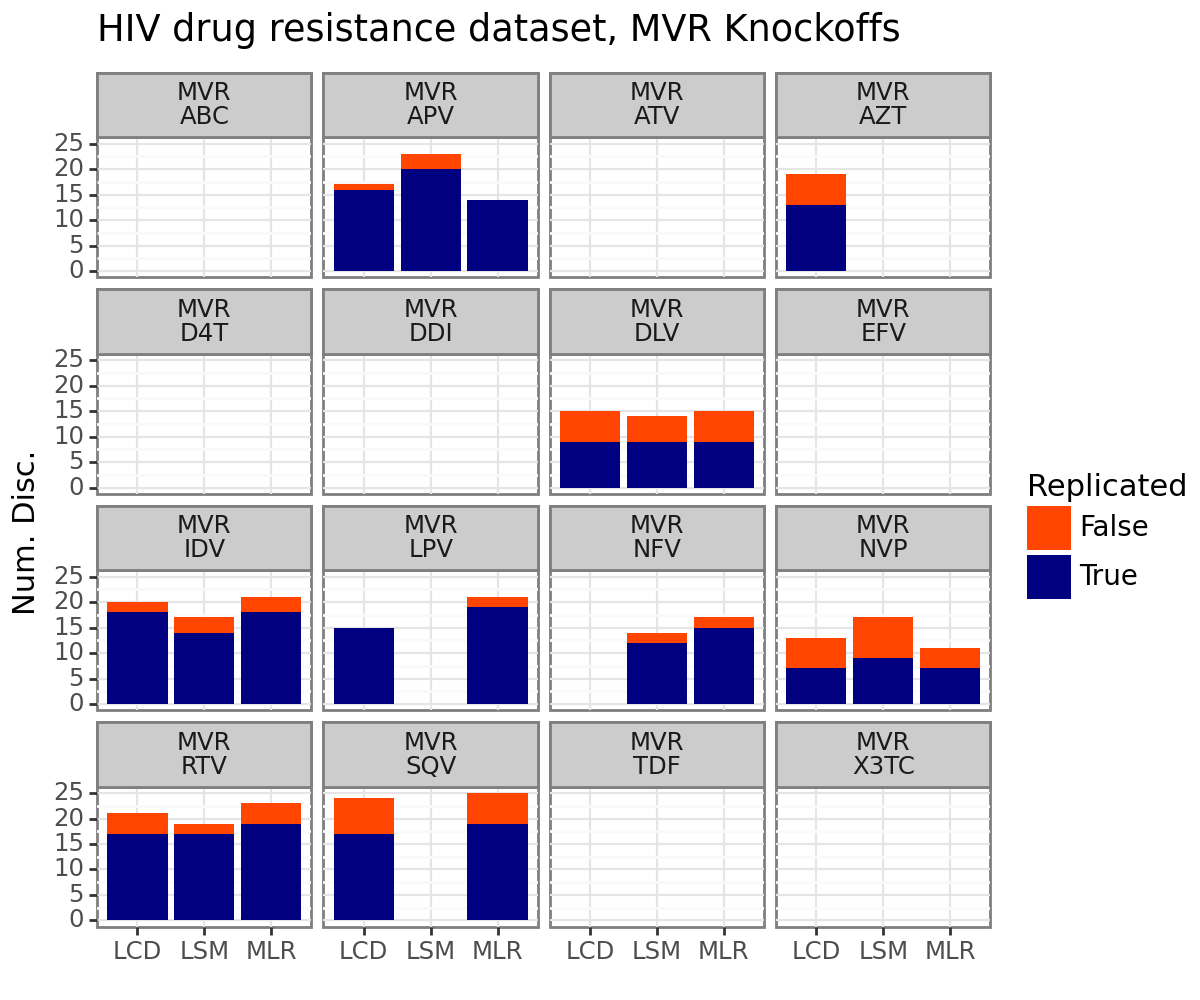

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: section4/hiv_bydrug_SDP.png


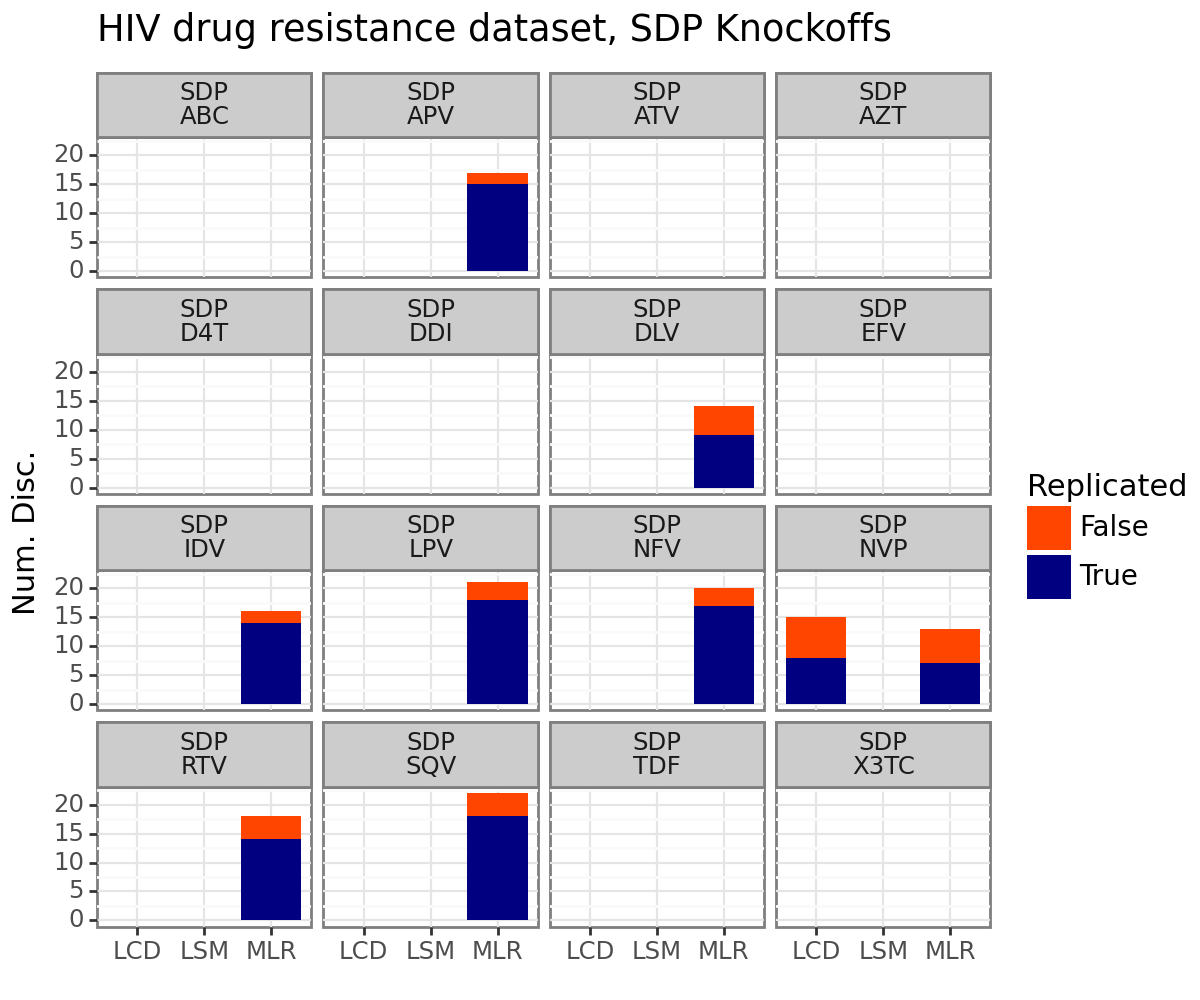

In [198]:
for S_method in ['MVR', 'SDP']:
    g = (
        ggplot(rej.loc[rej['S_method'] == S_method], aes(x='fstat', y='ndisc', fill='true'))
        + geom_col(position='stack')
        + facet_wrap("~S_method+resistance", ncol=4)#, labeller='label_both')
        + scale_fill_manual(['orangered', 'navy', 'cornflowerblue'])
        + theme_bw()
        + theme(
            figure_size=(6,5), 
            #legend_position=(1.12,0.5), 
            legend_text=element_text(size=10),
            legend_title=element_text(size=11),
            #plot_margin=0,
            #subplots_adjust={'right':0.85,}
        )
        + labs(
            x='',#'Feature Statistic',
            fill='Replicated',
            y='Num. Disc.', 
            title=f"HIV drug resistance dataset, {S_method} Knockoffs"
        )
    )
    g.save(f"section4/hiv_bydrug_{S_method}.png", dpi=500)
    print(g)

## Fund replication analysis

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


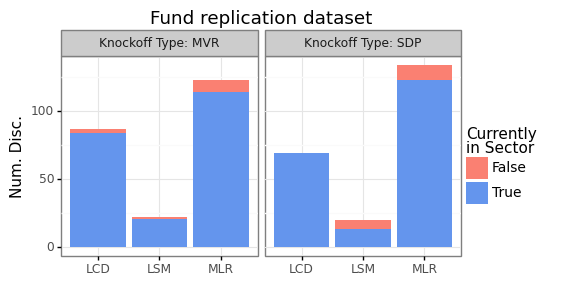

In [145]:
# read data
nyears, q = 10, 0.05
results = pd.read_csv(
    f"../real_data/fund_replication/results/kf_results_{nyears}yr.csv"
)
rej = results.copy()#.loc[results['q'] == q]
rej['S_method'] = rej['S_method'].str.upper()
rej['fstat'] = rej['fstat'].str.upper()
rej = rej.loc[~rej['S_method'].str.contains("EQUI")]#, 'S_method'] = 'EQUI'
# melt
rej = rej.drop("ndisc", axis='columns')
rej = pd.melt(
    rej, 
    id_vars=['fstat', 'S_method', 'fund', 'q'],
    var_name='true',
    value_name='ndisc'
)
rej['true'] = pd.Categorical(rej['true'].str.contains('true'))

# Summary statistics
trej = rej.groupby(['fstat', 'S_method', 'true', 'q'])['ndisc'].sum().reset_index()
g = (
    ggplot(trej.loc[trej['q'] == q], 
           aes(x='fstat', y='ndisc', fill='true'))
    + geom_col(position='stack')
    + facet_wrap("~S_method", labeller=lambda x: f"Knockoff Type: {x}")
    + scale_fill_manual(['salmon', 'cornflowerblue'])
    # + scale_fill_manual(['orangered', 'navy', 'cornflowerblue'])
    + theme_bw()
    + theme(
        figure_size=(4,2), 
        legend_position=(1.1,0.5),
        legend_text=element_text(size=10),
        legend_title=element_text(size=11),
        plot_margin=0
    )
    + labs(
        x=None,#'Feature Statistic',
        fill='Currently\nin Sector\n',
        y='Num. Disc.', 
        title=f"Fund replication dataset"
    )
)
g.save(f"section4/fund_rep.png", dpi=500)
print(g)

In [158]:
results['fdp'] = results['ndisc_false'] / np.maximum(results['ndisc'], 1)
fdrtable = results.groupby(['S_method', 'fstat', 'q'])['fdp'].mean()
print(fdrtable.to_latex())

\begin{tabular}{lllr}
\toprule
    &     &      &       fdp \\
S\_method & fstat & q &           \\
\midrule
mvr & lcd & 0.05 &  0.013636 \\
    & lsm & 0.05 &  0.004545 \\
    & mlr & 0.05 &  0.038571 \\
sdp & lcd & 0.05 &  0.000000 \\
    & lsm & 0.05 &  0.035000 \\
    & mlr & 0.05 &  0.039002 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_13481/3269490466.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Nodewise knockoffs

In [438]:
k = 50
output = []
columns = ["ndisc", "S_method", "fstat", "q"]
W_dict = {}
for S_method in ['mvr', 'sdp']:
    W_dict[S_method] = {}
    for fstat in ['lcd', 'lsm', 'mlr']:
        W = pd.read_csv(f"../real_data/nodewise_knock/results/W_{fstat}_{S_method}_top{k}.csv", index_col=0)
        W_dict[S_method][fstat] = W
        for q in np.arange(200) / 400:
            T = knockpy.ggm.compute_ggm_threshold(W.values, fdr=q, logic='and', a=1)
            edges = knockpy.ggm.discovered_edges(W.values, T=T, logic='and')
            output.append(
                [edges.sum() / 2, S_method, fstat.upper(), q]
            )
out_df = pd.DataFrame(output, columns=columns)
out_df['S_method'] = out_df['S_method'].str.upper()

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


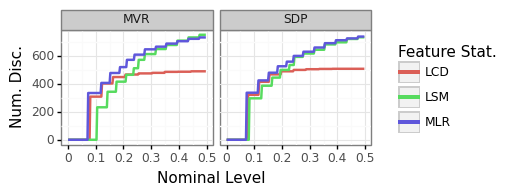

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 1.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: section4/knockoff_ggm.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [439]:
g = (
ggplot(
    out_df, 
    aes(x='q', y='ndisc', color='fstat')
    )
    + geom_line(size=1)
    #+ geom_point()
    + facet_wrap("~S_method")
    + theme_bw()
    + theme(figure_size=(4,1.5))
    + labs(
        x="Nominal Level",
        y="Num. Disc.",
        color='Feature Stat.'
    )
)
print(g)
g.save(f"section4/knockoff_ggm.png", dpi=500)